# Обучение нейросети


Сеть, которую мы создали в предыдущей части, не очень умна, она ничего не знает о наших рукописных цифрах. Нейронные сети с нелинейными активациями работают как универсальные аппроксиматоры функций. Есть некоторая функция, которая отображает ваш вход в какой-то выход. Например, изображения рукописных цифр в вероятности классов. Мощь нейронных сетей заключается в том, что мы можем обучить их приближать эту функцию, и в целом, любую функцию, если есть достаточно данных и времени.

![image.png](attachment:image.png)

Сначала сеть случайна, она не знает функции, сопоставляющей входы и выходы. Мы обучаем сеть, показывая ей примеры реальных данных, а затем корректируем параметры сети так, чтобы она приближалась к этой функции.

Чтобы найти эти параметры, нам нужно знать, насколько плохо сеть прогнозирует реальные результаты. Для этого мы рассчитываем **функцию потерь** (также называемую **loss**), меру нашей ошибки прогнозирования. Например, среднеквадратичную ошибку часто используются в задачах регрессии и двоичной классификации.


$$
\large \ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$


где $n$ это число обучающих примеров, $y_i$ это истинные метки, а $\hat{y}_i$ это предсказанные метки.


Минимизируя эту функцию ошибки по отношению к параметрам сети, мы можем найти конфигурации, в которых ошибка минимальна, и сеть способна предсказать правильные метки с высокой точностью. Мы находим этот минимум, используя процесс под названием **градиентный спуск**. Градиент является наклоном функции потерь и указывает в направлении наискорейшего роста. Чтобы достичь минимума как можно быстрее, мы хотим следовать антиградиенту (вниз). Вы можете думать об этом как о спуске с горы, следуя по самому крутому склону к основанию.


## Backpropagation

Для однослойных сетей, градиентный спуск прост в реализации. Однако это более сложно для более глубоких, многослойных нейронных сетей, подобных той, которую мы создали. Достаточно сложно, что понадобилось около 30 лет, чтобы исследователи выяснили, как обучать многослойные сети.

Обучение многослойных сетей осуществляется с помощью **метода обратного распространения ошибки**, который на самом деле является просто применением правила производной сложной функции из матанализа. Это проще всего понять, если преобразовать двухслойную сеть в графическое представление.

![image.png](attachment:image.png)

При прямом прохождении через сеть наши данные и операции идут здесь снизу вверх. Мы передаем вход $ x $ через линейное преобразование $ L_1 $ с весами $ W_1 $ и смещениями $ b_1 $. Выходные данные затем проходят через сигмоид $ S $ и другое линейное преобразование $ L_2 $. Наконец, мы рассчитываем ошибку $ \ell $. Мы используем ошибку как меру того, насколько плохи прогнозы сети. Тогда цель состоит в том, чтобы отрегулировать веса и смещения, чтобы минимизировать потери.

Чтобы тренировать веса с градиентным спуском, мы распространяем градиент потерь обратно по сети. Каждая операция имеет некоторый градиент между входами и выходами. Когда мы отправляем градиенты назад, мы умножаем входящий градиент на градиент операции. Математически это действительно просто вычисление градиента ошибки по весам с использованием правила производной сложной функции.

$$
\large \frac{\partial \ell}{\partial W_1} = \frac{\partial L_1}{\partial W_1} \frac{\partial S}{\partial L_1} \frac{\partial L_2}{\partial S} \frac{\partial \ell}{\partial L_2}
$$


Мы обновляем наши веса с шагом $\alpha$. 

$$
\large W^\prime_1 = W_1 - \alpha \frac{\partial \ell}{\partial W_1}
$$


## Функции ошибок в PyTorch

Давайте начнем с того, что посчитаем ошибку с помощью PyTorch. Через модуль `nn` PyTorch позволяет считать подобные функции. Например, ошибка кросс-энтропии (` nn.CrossEntropyLoss`). Обычно за функцию потерь отвечает параметр `criterion`. Как отмечалось в предыдущей части, с такой задачей классификации, как MNIST, мы используем функцию softmax для прогнозирования вероятностей классов. С выходом softmax мы используем кросс-энтропию в качестве функции потерь. 

[Документация `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss),

> Эта функция комбинирует `nn.LogSoftmax()` и `nn.NLLLoss()` в одном классе.
>
> Под входом ожидаются числовые оценки классов (scores)

Это означает, что нам нужно передать необработанный вывод нашей сети в лосс, а не вывод функции softmax. Этот необработанный вывод обычно называется *logits* (логиты) или *scores*. Мы используем логиты, потому что softmax дает вам вероятности, которые часто будут очень близки к нулю или единице, но числа с плавающей точкой не могут точно представлять значения, близкие к нулю или единице (https://docs.python.org/3/tutorial/floatingpoint.html ). Обычно лучше избегать вычислений с вероятностями, поэтому мы используем логарифмические вероятности.


In [0]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [0]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))


# Define the loss
criterion = nn.CrossEntropyLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3016, grad_fn=<NllLossBackward>)


Возможно, удобнее считать лосс с `nn.LogSoftmax` или `F.log_softmax` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.LogSoftmax)). Для получения вероятностей, нужно пропустить полученные значения через экспоненту `torch.exp(output)`. С таким выводом нужно использовать negative log likelihood loss, `nn.NLLLoss` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss)).

>**Упражнение:** Создайте модель, которая возвращает log-softmax в качестве выходных данных и рассчитайте потери, используя negative log likelihood loss. Обратите внимание, что для `nn.LogSoftmax` и` F.log_softmax` вам необходимо соответствующим образом установить аргумент ключевого слова `dim`. `dim = 0` вычисляет softmax по строкам, и каждый столбец суммируется в 1, в то время как` dim = 1` вычисляет по столбцам, и каждая строка суммируется в 1. Подумайте, каким должен быть вывод, и выберите `dim` соответствующим образом.

In [0]:
# TODO: Build a feed-forward network
model= nn.Sequential(nn.Linear(784, 128),
                     nn.ReLU(),
                     nn.Linear(128, 64),
                     nn.ReLU(),
                     nn.Linear(64, 10),
                     nn.LogSoftmax(dim=1))

# TODO: Define the loss
criterion = nn.NLLLoss()

### Run this to check your work
# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3040, grad_fn=<NllLossBackward>)


## Autograd

Теперь, когда мы знаем, как рассчитать потери, как мы можем использовать их для обратного распространения? Torch предоставляет модуль autograd для автоматического расчета градиентов тензоров. Мы можем использовать его для расчета градиентов всех наших параметров относительно потерь. Автоград работает, отслеживая операции, выполняемые над тензорами, а затем проходит назад по этим операциям, вычисляя градиенты по пути. Чтобы PyTorch отслеживал операции над тензором и вычислял градиенты, вам нужно установить `require_grad = True` для тензора. Вы можете сделать это при создании с помощью ключевого слова `require_grad` или в любое время с помощью `x.requires_grad_(True)`.

Вы можете отключить градиенты для блока кода с помощью содержимого `torch.no_grad ()`:

```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

Кроме того, вы можете включить или выключить градиенты используя `torch.set_grad_enabled (True | False)`.

Градиенты вычисляются относительно некоторой переменной `z` с помощью` z.backward() `. Это делает обратный проход через операции, результат которых хранится в `z`.

In [0]:
x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[-0.5029, -0.1096],
        [ 0.2689, -0.2071]], requires_grad=True)


In [0]:
y = x**2
print(y)

tensor([[0.2529, 0.0120],
        [0.0723, 0.0429]], grad_fn=<PowBackward0>)


Ниже можно увидеть, в результате какой операции была создана `y`, операция возведения в степень `PowBackward0`.

In [0]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

Модуль autograd отслеживает эти операции и знает, как рассчитать градиент для каждой из них. Таким образом, он может рассчитывать градиенты для цепочки операций относительно любого тензора. Давайте уменьшим тензор `y` до скалярного значения, среднего.

In [0]:
z = y.mean()
print(z)

tensor(0.0950, grad_fn=<MeanBackward0>)


Вы можете проверить градиенты для `x` и` y`, но сейчас они пусты.

In [0]:
print(x.grad)

None


Чтобы вычислить градиенты, вам нужно запустить метод `.backward` для переменной, например,` z`. Это вычислит градиент `z` по ` x`

$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [0]:
z.backward()
print(x.grad)
print(x/2)

tensor([[-0.2514, -0.0548],
        [ 0.1344, -0.1035]])
tensor([[-0.2514, -0.0548],
        [ 0.1344, -0.1035]], grad_fn=<DivBackward0>)


Эти вычисления градиентов особенно полезны для нейронных сетей. Для обучения нам нужны градиенты ошибки по весам. С помощью PyTorch мы пропускаем данные вперед по сети, чтобы рассчитать ошибку, а затем возвращаемся назад, чтобы рассчитать градиенты относительно ошибки. Когда у нас есть градиенты, мы можем сделать шаг градиентного спуска.

## Loss и Autograd вместе

Когда мы создаем сеть с помощью PyTorch, все параметры модели инициализируются с `require_grad = True`. Это означает, что когда мы вычисляем ошибку `loss` и вызываем функцию `loss.backward()`, вычисляются градиенты для параметров модели. Эти градиенты используются для обновления весов с градиентным спуском. Ниже вы можете увидеть пример расчета градиентов с помощью обратного прохода.

In [0]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)

In [0]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0062, -0.0062, -0.0062,  ..., -0.0062, -0.0062, -0.0062],
        [-0.0031, -0.0031, -0.0031,  ..., -0.0031, -0.0031, -0.0031],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005],
        [-0.0021, -0.0021, -0.0021,  ..., -0.0021, -0.0021, -0.0021],
        [ 0.0028,  0.0028,  0.0028,  ...,  0.0028,  0.0028,  0.0028]])


## Обучаем сеть!

Осталась последняя часть, которая нам нужна чтобы начать тренировать модель - оптимизатор, который мы будем использовать для обновления весов с помощью градиентов. Мы получаем их из [`optim` пакета] PyTorch (https://pytorch.org/docs/stable/optim.html). Например, мы можем использовать стохастический градиентный спуск с `optim.SGD`. Вы можете увидеть, как определить оптимизатор ниже.

In [0]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)


Теперь мы знаем, как использовать отдельные части, поэтому пришло время посмотреть, как они работают вместе. Давайте рассмотрим только один шаг обучения, прежде чем перебирать все данные. Общий процесс с PyTorch:

* Сделать прямой проход через сеть
* Использовать выход сети для расчета ошибки
* Выполнить обратный проход по сети с помощью loss.backward () для вычисления градиентов.
* Сделать шаг с оптимизатором, чтобы обновить веса

Ниже я пройду один тренировочный шаг и распечатаю веса и градиенты, чтобы вы могли увидеть, как они меняются. Обратите внимание, что у меня есть строка кода `optimizer.zero_grad ()`. Когда вы делаете несколько обратных проходов с одинаковыми параметрами, градиенты накапливаются. Это означает, что вам нужно обнулять градиенты на каждом тренировочном проходе, иначе вы сохраните градиенты от предыдущих тренировочных партий.

In [0]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[-0.0144,  0.0010,  0.0070,  ..., -0.0006, -0.0069, -0.0077],
        [-0.0092, -0.0259,  0.0253,  ...,  0.0125,  0.0074,  0.0353],
        [ 0.0106, -0.0168,  0.0047,  ..., -0.0157,  0.0157, -0.0318],
        ...,
        [ 0.0338,  0.0296,  0.0142,  ..., -0.0114, -0.0218,  0.0091],
        [ 0.0044, -0.0168, -0.0176,  ...,  0.0332,  0.0268, -0.0192],
        [ 0.0183,  0.0037,  0.0250,  ...,  0.0156, -0.0012, -0.0301]],
       requires_grad=True)
Gradient - tensor([[-1.5018e-03, -1.5018e-03, -1.5018e-03,  ..., -1.5018e-03,
         -1.5018e-03, -1.5018e-03],
        [-2.6457e-03, -2.6457e-03, -2.6457e-03,  ..., -2.6457e-03,
         -2.6457e-03, -2.6457e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 1.0704e-04,  1.0704e-04,  1.0704e-04,  ...,  1.0704e-04,
          1.0704e-04,  1.0704e-04],
        [-2.2410e-03, -2.2410e-03, -2.2410e-03,  ..., -2.2410e

In [0]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[-0.0144,  0.0010,  0.0070,  ..., -0.0006, -0.0069, -0.0077],
        [-0.0092, -0.0259,  0.0253,  ...,  0.0125,  0.0074,  0.0354],
        [ 0.0106, -0.0168,  0.0047,  ..., -0.0157,  0.0157, -0.0318],
        ...,
        [ 0.0338,  0.0296,  0.0142,  ..., -0.0114, -0.0219,  0.0091],
        [ 0.0044, -0.0168, -0.0176,  ...,  0.0332,  0.0268, -0.0192],
        [ 0.0183,  0.0037,  0.0250,  ...,  0.0156, -0.0012, -0.0301]],
       requires_grad=True)


### Обучение

Теперь мы поместим этот алгоритм в цикл, чтобы модель могла просмотреть все изображения. Некоторая терминология, один проход по всему набору данных называется *эпохой*. Итак, здесь мы собираемся пройтись по `trainloader`, чтобы получить наши тренировочные батчи. Для каждого батча, мы выполняем проход, где рассчитываем потери, делаем обратный проход и обновляем весовые коэффициенты.

> **Упражнение:** Реализовать обучающий проход (туда-назад) для нашей сети. Если вы реализовали это правильно, вы должны увидеть уменьшение ошибки обучения с каждой эпохой.

In [0]:
## Your solution here

model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.03)
#output = model(images)
epochs = 5
for e in range(epochs):
    running_loss = 0
    
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        
        # TODO: Training pass
        output = model(images)
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    else:
      print(f"Training loss:  {running_loss/len(trainloader)}")

Training loss:  0.6140206825297906
Training loss:  0.2790490790669407
Training loss:  0.21097329275996318
Training loss:  0.1675457457886703
Training loss:  0.1411747891487661


Когда модель обучена, мы можем посмотреть на предсказания:

tensor([[1.0481, 0.8673, 0.9585, 1.1332, 1.1151, 0.9158, 0.9815, 1.1369, 0.8517,
         0.9316]])

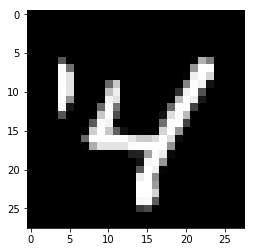

In [0]:
%matplotlib inline
import helper

images, labels = next(iter(trainloader))
img = images[1].view(1, 784)
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
ps
#elper.view_classify(img.view(1, 28, 28), ps)

Шикарно